In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
pwd

'/Users/kelvin/Toxicity/notebooks'

In [3]:
train_path = '/Users/kelvin/Toxicity/data/train.csv'
test_path = '/Users/kelvin/Toxicity/data/test.csv'

In [4]:
df = pd.read_csv(train_path)

In [5]:
df.target[df.target >= 0.5]
text = df.comment_text
df['class_target'] = np.where(df['target'] >= 0.5, 'toxic', 'non_toxic')

In [6]:
df.class_target.value_counts(normalize=True)*100

non_toxic    92.003098
toxic         7.996902
Name: class_target, dtype: float64

### Regular Expressions to Clean Text

In [7]:
import re
import string

In [8]:
# Before preprocessing
text.head(5)

0    This is so cool. It's like, 'would you want yo...
1    Thank you!! This would make my life a lot less...
2    This is such an urgent design problem; kudos t...
3    Is this something I'll be able to install on m...
4                 haha you guys are a bunch of losers.
Name: comment_text, dtype: object

In [9]:
# Text preprocessing steps - remove numbers, captial letters and punctuation
alphabetic = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
# text
text = text.map(alphabetic).map(punc_lower)
text.head()                        

0    this is so cool  it s like   would you want yo...
1    thank you   this would make my life a lot less...
2    this is such an urgent design problem  kudos t...
3    is this something i ll be able to install on m...
4                 haha you guys are a bunch of losers 
Name: comment_text, dtype: object

In [10]:
X = text
y = df['class_target']

In [12]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
from sklearn.feature_extraction.text import CountVectorizer

cv1 = CountVectorizer(stop_words='english')

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

In [18]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english')

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

In [14]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
# Train the first model
lr.fit(X_train_cv1, y_train)
y_pred_cv1 = lr.predict(X_test_cv1)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# Train the second model
lr.fit(X_train_cv2, y_train)
y_pred_cv2 = lr.predict(X_test_cv2)

In [22]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

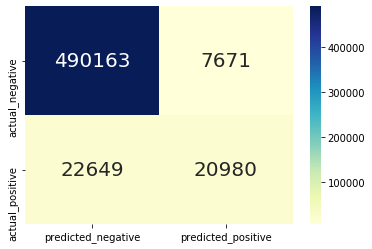

In [23]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred_cv1)

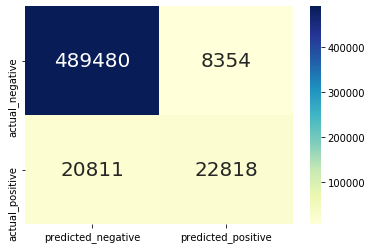

In [24]:
# The heat map for the second logistic regression model
cm2 = conf_matrix(y_test, y_pred_cv2)

In [25]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg1', 'LogReg2']
results

,LogReg1,LogReg2
Accuracy,0.944,0.946
Precision,0.732,0.732
Recall,0.481,0.523
F1 Score,0.581,0.610


In [27]:
# Fit the first Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv1, y_train)

y_pred_cv1_nb = mnb.predict(X_test_cv1)

In [28]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv2, y_train)

y_pred_cv2_nb = bnb.predict(X_test_cv2)

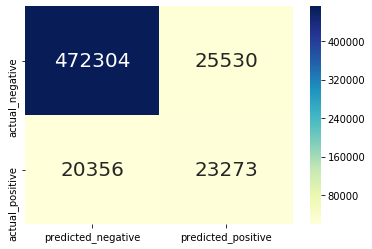

In [29]:
# Here's the heat map for the first Naive Bayes model
cm3 = conf_matrix(y_test, y_pred_cv1_nb)

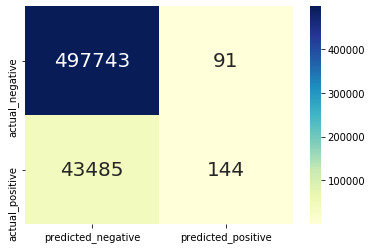

In [30]:
# Here's the heat map for the second Naive Bayes model
cm4 = conf_matrix(y_test, y_pred_cv2_nb)

In [31]:
# Compile all of the error metrics into a dataframe for comparison
results_nb = pd.DataFrame(list(zip(cm3, cm4)))
results_nb = results_nb.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_nb.columns = ['NB1', 'NB2']
results_nb

results = pd.concat([results, results_nb], axis=1)
results

,LogReg1,LogReg2,NB1,NB2
Accuracy,0.944,0.946,0.915,0.920
Precision,0.732,0.732,0.477,0.613
Recall,0.481,0.523,0.533,0.003
F1 Score,0.581,0.610,0.503,0.006


### Try using TF-IDF instead of Count Vectorizer

In [32]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


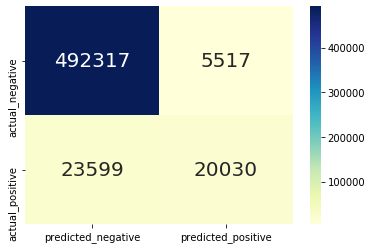

In [33]:
# Fit the first logistic regression on the TF-IDF data
lr.fit(X_train_tfidf1, y_train)
y_pred_tfidf1_lr = lr.predict(X_test_tfidf1)
cm5 = conf_matrix(y_test, y_pred_tfidf1_lr)

In [ ]:
# Fit the first Naive Bayes model on the TF-IDF data
mnb.fit(X_train_tfidf1.toarray(), y_train)
y_pred_tfidf1_nb = mnb.predict(X_test_tfidf1)
cm7 = conf_matrix(y_test, y_pred_tfidf1_nb)

In [ ]:
# Compile all of the error metrics into a dataframe for comparison
results_tf = pd.DataFrame(list(zip(cm5, cm7)))
results_tf = results_tf.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results_tf.columns = ['LR1-TFIDF', 'LR2-TFIDF', 'NB1-TFIDF', 'NB2-TFIDF']
results_tf

results = pd.concat([results, results_tf], axis=1)
results